# <center>Data Dive (Eclipse date prediction)

Submitted by:

## Ritwika Pal (1805689)

### Importing the libraries and the datasets

In [1400]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from scipy import stats
from forex_python.converter import CurrencyRates
from collections import defaultdict
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,accuracy_score
import astropy.time
import dateutil.parser
import math
from statsmodels.distributions.empirical_distribution import ECDF
from feature_engine import transformation as vt
from feature_engine.discretisation import EqualWidthDiscretiser
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [1401]:
d = pd.read_csv('train.csv')

In [1402]:
d

,Unnamed: 0,Catalog Number,Calendar Date,Eclipse Time,Delta T (s),Lunation Number,Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration
0,0,1,-1999 June 12,3:14:51,NaN,-49456,NaN,T,NaN,NaN,6.0N,33.3W,NaN,344,247,06m37s
1,1,2,-1999 December 5,23:45:23,46426.0,-49450,10.0,A,-0.2317,0.9382,32.9S,10.8E,76.0,21,236,06m44s
2,2,3,-1998 June 1,18:09:16,46415.0,-49444,15.0,T,0.4994,1.0284,46.2N,83.4E,60.0,151,111,02m15s
3,3,4,-1998 November 25,5:57:03,46403.0,-49438,20.0,A,-0.9045,0.9806,67.8S,143.8W,25.0,74,162,01m14s
4,4,5,-1997 April 22,13:19:56,46393.0,-49433,-13.0,P,-1.4670,0.1611,60.6S,106.4W,0.0,281,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9513,9513,9514,2002 December 4,7:32:16,64.0,36,142.0,T,-0.3020,1.0244,39.5S,59.6E,72.0,16,87,02m04s
9514,9514,9515,2003 May 31,4:09:22,64.0,42,147.0,An,0.9960,0.9384,66.6N,24.5W,3.0,35,-,03m37s
9515,9515,9516,2003 November 23,22:50:22,64.0,48,152.0,T,-0.9638,1.0379,72.7S,88.4E,15.0,111,495,01m57s
9516,9516,9517,2004 April 19,13:35:05,65.0,53,119.0,P,-1.1335,0.7367,61.6S,44.3E,0.0,295,NaN,NaN


In [1403]:
test = pd.read_csv('test.csv')

In [1404]:
test_big = test.copy()

In [1405]:
d.describe()

,Unnamed: 0,Catalog Number,Delta T (s),Lunation Number,Saros Number,Gamma,Eclipse Magnitude,Sun Altitude,Sun Azimuth
count,9518.000000,9518.000000,9498.000000,9518.000000,9508.000000,9502.000000,9494.000000,9504.000000,9518.000000
mean,4758.500000,4759.500000,14739.587808,-24755.667472,71.207615,-0.001126,0.813446,36.513468,180.164951
std,2747.754265,2747.754265,14015.401658,14315.343716,39.216839,0.900437,0.299681,32.413091,110.644721
min,0.000000,1.000000,-6.000000,-49456.000000,-13.000000,-1.569000,0.000000,0.000000,0.000000
25%,2379.250000,2380.250000,1525.500000,-37206.500000,39.000000,-0.785600,0.679825,0.000000,89.000000
50%,4758.500000,4759.500000,10579.500000,-24792.000000,71.000000,-0.001400,0.950600,38.000000,180.000000
75%,7137.750000,7138.750000,25461.750000,-12284.500000,103.000000,0.780350,1.017600,66.000000,272.000000
max,9517.000000,9518.000000,46426.000000,59.000000,155.000000,1.565000,1.081300,90.000000,360.000000


In [1406]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9518 entries, 0 to 9517
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         9518 non-null   int64  
 1   Catalog Number     9518 non-null   int64  
 2   Calendar Date      9518 non-null   object 
 3   Eclipse Time       9518 non-null   object 
 4   Delta T (s)        9498 non-null   float64
 5   Lunation Number    9518 non-null   int64  
 6   Saros Number       9508 non-null   float64
 7   Eclipse Type       9518 non-null   object 
 8   Gamma              9502 non-null   float64
 9   Eclipse Magnitude  9494 non-null   float64
 10  Latitude           9518 non-null   object 
 11  Longitude          9518 non-null   object 
 12  Sun Altitude       9504 non-null   float64
 13  Sun Azimuth        9518 non-null   int64  
 14  Path Width (km)    6163 non-null   object 
 15  Central Duration   6163 non-null   object 
dtypes: float64(5), int64(4),

### Dropping the unique columns

In [1407]:
print(d['Catalog Number'].nunique())
d.drop(columns=['Catalog Number'], inplace=True)
test.drop(columns=['Catalog Number'], inplace=True)

9518


In [1408]:
print(d['Unnamed: 0'].nunique())
d.drop(columns=['Unnamed: 0'], inplace=True)
test.drop(columns=['Unnamed: 0'], inplace=True)

9518


In [1409]:
print(d['Lunation Number'].nunique())
d.drop(columns=['Lunation Number'], inplace=True)
test.drop(columns=['Lunation Number'], inplace=True)

9518


Since the columns :
<ul>
    <b>
        <li> Catalog Number</li>
        <li> Unnamed: 0</li>
        <li> Lunation Number</li>
    </b>
</ul>
are all unique, we'll drop them, because the model will learn nothing from it.

We can create a pandas profiling to have a closer look at the features 

In [1410]:
d['Eclipse Time'].nunique()

9045

This column is also almost unqiue, so we'll drop it.

In [1411]:
d.drop(columns=['Eclipse Time'], inplace=True)
test.drop(columns=['Eclipse Time'], inplace=True)

In [1412]:
from pandas_profiling import ProfileReport
report = ProfileReport(d, title='train set',explorative=True)
report.to_file(output_file='output.html')

### Analyzing Calendar Date

We will first convert the string into the desired format of : 01:05:25 for example. We create a function and then use apply method to convert every row calendar date to te required format, and whatever we do to the trainig set, the same is done to the test set.

In [1413]:
months = {'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June': 6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
months1 = {'Jan':1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun': 6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}


def to_date(s):
    s = s.split()
    if len(s) == 1:
        l =  s[0].split('-')
        l[1] = str(months1[l[1]])
        return l[0]+':'+l[1]+':'+l[2]
    #print(s)
    s[1] = str(months[s[1]])
    return s[0]+':'+s[1]+':'+s[2]


In [1414]:
d['Calendar Date'] = d['Calendar Date'].apply(lambda x:to_date(x))
test['Calendar Date'] = test['Calendar Date'].apply(lambda x:to_date(x))

In [1415]:
test

,Calendar Date,Delta T (s),Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration
0,2005:4:8,65.0,129.0,H,-0.3473,1.0074,10.6S,119.0W,70.0,332,27,00m42s
1,2005:10:3,65.0,134.0,A,0.3306,0.9576,12.9N,28.7E,71.0,209,162,04m32s
2,2006:3:29,65.0,139.0,T,0.3843,1.0515,23.2N,16.7E,67.0,149,184,04m07s
3,2006:9:22,65.0,144.0,A,-0.4062,0.9352,20.6S,9.1W,66.0,31,261,07m09s
4,2007:3:19,65.0,149.0,P,1.0728,0.8756,61.0N,55.5E,0.0,92,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2375,2998:12:10,4414.0,187.0,P,1.2838,0.4773,67.2N,145.0E,0.0,179,NaN,NaN
2376,2999:5:6,4417.0,154.0,T,0.8388,1.0566,71.5N,177.3E,33.0,146,345,03m25s
2377,2999:10:30,4420.0,159.0,A-,-1.0023,0.9586,70.9S,84.7W,0.0,137,-,-
2378,3000:4:26,4424.0,164.0,T,0.1310,1.0222,21.1N,18.4W,82.0,166,76,02m11s


We need to predict the Calendar Date. Now since, the eclipses are periodic. So, we'll convert the date to the Julian Day. The Julian Day Count is a uniform count of days from a remote epoch in the past (-4712 January 1, 12 hours Greenwich Mean Time (Julian proleptic Calendar) = 4713 BCE January 1, 12 hours GMT (Julian proleptic Calendar) = 4714 BCE November 24, 12 hours GMT (Gregorian proleptic Calendar)). At this instant, the Julian Day Number is 0. This is done, because we need a point, a particular date from which the difference between the current date of a particular row can be found. This difference s the Julian Day, or Julian day number.

In [1416]:
def to_day_number(s):
    l = s.split(':')
    year = int(l[0])
    month = int(l[1])
    day = int(l[2])
    if month == 1 or month == 2:
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month 
    # this checks where we are in relation to October 15, 1582, the beginning
    # of the Gregorian calendar.
    if ((year < 1582) or
        (year == 1582 and month < 10) or
        (year == 1582 and month == 10 and day < 15)):
        # before start of Gregorian calendar
        B = 0
    else:
        # after start of Gregorian calendar
        A = math.trunc(yearp / 100.)
        B = 2 - A + math.trunc(A / 4.)
        
    if yearp < 0:
        C = math.trunc((365.25 * yearp) - 0.75)
    else:
        C = math.trunc(365.25 * yearp)
        
    D = math.trunc(30.6001 * (monthp + 1))  
    jd = B + C + D + day + 1720994.5
    return jd

In [1417]:
d

,Calendar Date,Delta T (s),Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration
0,-1999:6:12,NaN,NaN,T,NaN,NaN,6.0N,33.3W,NaN,344,247,06m37s
1,-1999:12:5,46426.0,10.0,A,-0.2317,0.9382,32.9S,10.8E,76.0,21,236,06m44s
2,-1998:6:1,46415.0,15.0,T,0.4994,1.0284,46.2N,83.4E,60.0,151,111,02m15s
3,-1998:11:25,46403.0,20.0,A,-0.9045,0.9806,67.8S,143.8W,25.0,74,162,01m14s
4,-1997:4:22,46393.0,-13.0,P,-1.4670,0.1611,60.6S,106.4W,0.0,281,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9513,2002:12:4,64.0,142.0,T,-0.3020,1.0244,39.5S,59.6E,72.0,16,87,02m04s
9514,2003:5:31,64.0,147.0,An,0.9960,0.9384,66.6N,24.5W,3.0,35,-,03m37s
9515,2003:11:23,64.0,152.0,T,-0.9638,1.0379,72.7S,88.4E,15.0,111,495,01m57s
9516,2004:4:19,65.0,119.0,P,-1.1335,0.7367,61.6S,44.3E,0.0,295,NaN,NaN


In [1418]:
d['Time'] = d['Calendar Date'].apply(lambda x:to_day_number(x))
test['Time'] = test['Calendar Date'].apply(lambda x:to_day_number(x))

We will drop Calendar Date for now, since it won't be applied to our dataset anymore, we have already got the Julian day.

In [1419]:
d['Calendar Date'].nunique()
d.drop(columns=['Calendar Date'], inplace=True)
test.drop(columns=['Calendar Date'], inplace=True)

As another feature, we'll subtract the consecutive differences between the Juian Days. For example, if ith row has Julian day or simply what I have named as Time as 991261.5 and the i+1th row has Julian day as 991439.5, then the difference between the two that is 178 will be stored in the Diff column in the i+1th row. These are the consecuive differences, which can tell a lot about the eclipses. Eclipses are periodic, and so the time betwen each eclipse has to be recorded to get a visualizable pattern.

In [1420]:
d['Diff'] = d['Time'].diff()
test['Diff'] = test['Time'].diff()

### Correlation Matrix

<AxesSubplot:>

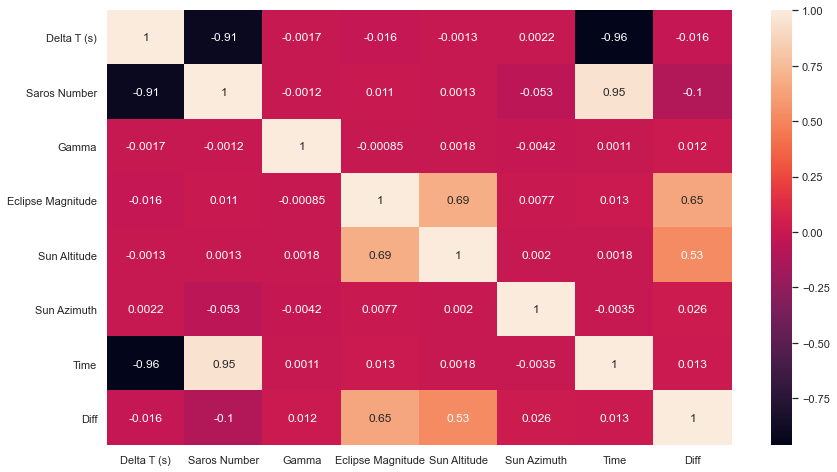

In [1421]:
corr=d.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr,annot=True)

The highly correlated features are as following :
<ul>
    <li>Delta T (s), Saros Number
    <li>Delta T (s), Time
    <li>Saros Number, Time
    <li>Eclipse Magnitude, Sun Altitude
    <li>Eclipse Magnitude, Diff
    <li>Sun Altitude, Diff
    <li>Eclipse Magnitude, Diff

### Pairplot

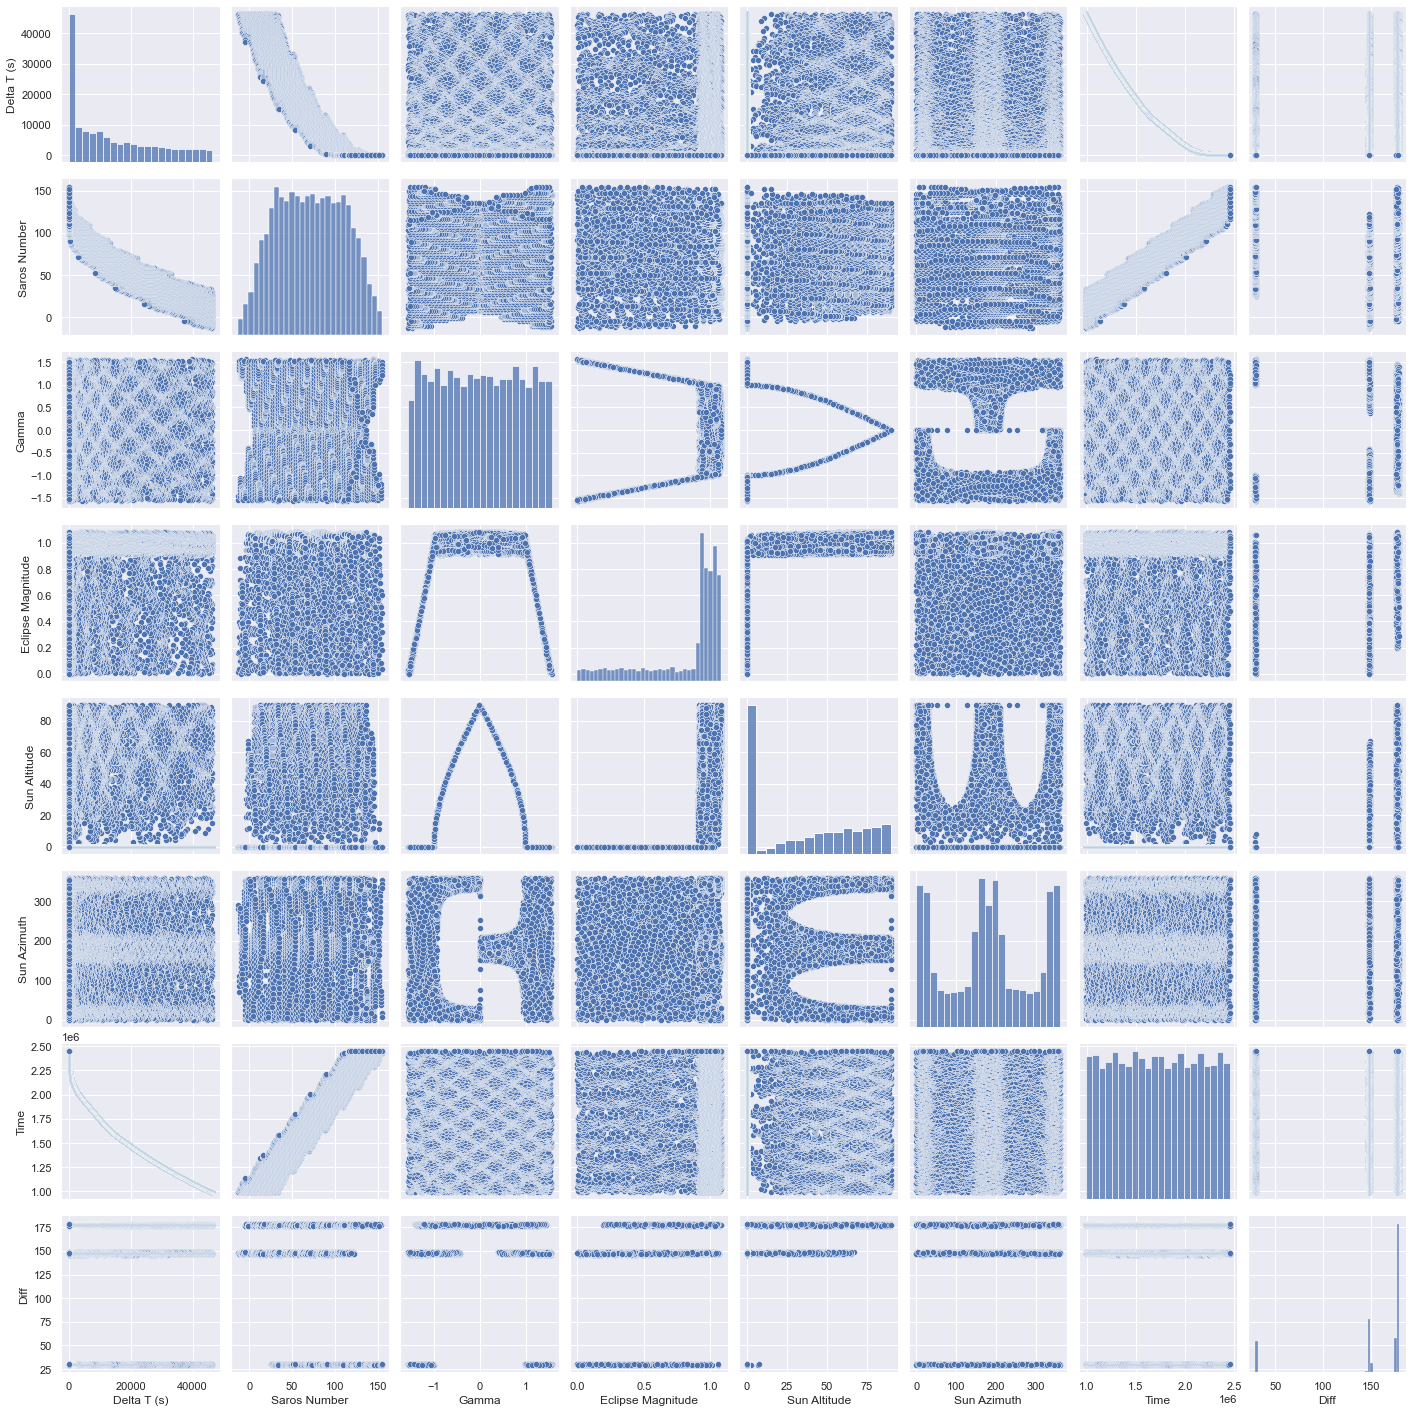

In [1422]:
sns.set()
sns.pairplot(d)

From the pariplot, we can notice some linear relationships which are : 
    <li>Delta T (s), Saros Number
    <li>Delta T (s), Time
    <li>Saros Number, Time
    

We shall look into these linear relationhips and the columns which have the correlation on the higher side 

### Analysis of highly collinear data

<AxesSubplot:xlabel='Time', ylabel='Saros Number'>

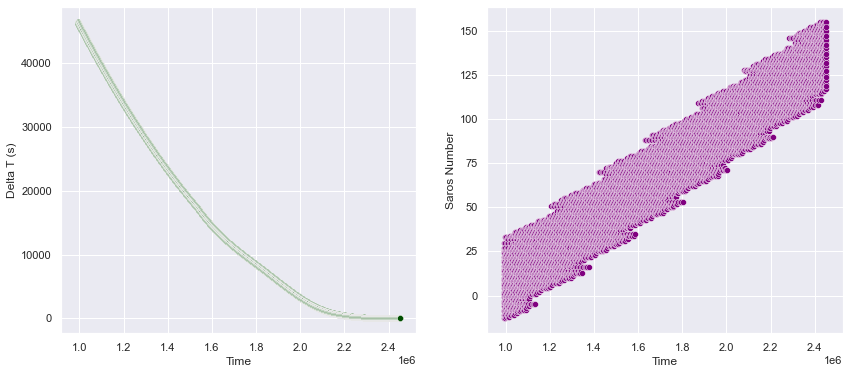

In [1423]:
fig,ax=plt.subplots(1,2,figsize=(14,6),squeeze=False)
sns.scatterplot(d['Time'], d['Delta T (s)'],ax = ax[0][0],color='#004d00')
sns.scatterplot(d['Time'], d['Saros Number'],ax = ax[0][1],color='purple')

From the first plot, we can definitely see negative correlation between Deta T (s) and the Julian Day time. As the Delta T(s) increases, the Time decreases.
From the second graph, we can derive that there is positive correlation between Saros Number and the Time. As the Saros Number increases, the Time increases.

<AxesSubplot:xlabel='Delta T (s)', ylabel='Saros Number'>

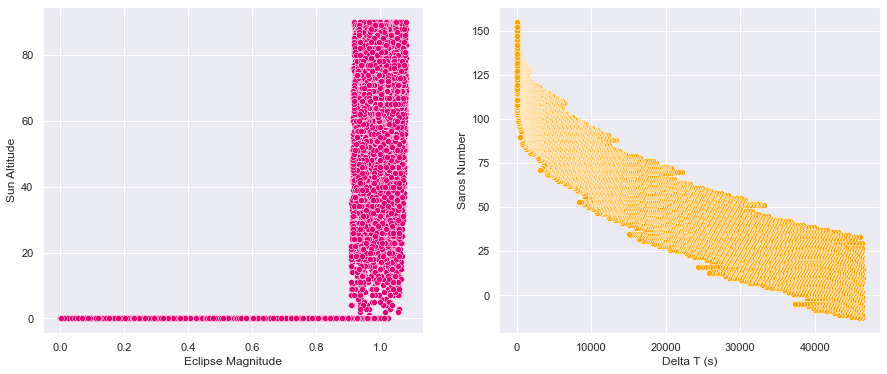

In [1424]:
fig,ax=plt.subplots(1,2,figsize=(15,6),squeeze=False)
sns.scatterplot(d['Eclipse Magnitude'], d['Sun Altitude'],color='#e60073', ax=ax[0][0])
sns.scatterplot(d['Delta T (s)'], d['Saros Number'],color='orange',ax=ax[0][1])

From the first plot, we can derive that the eclipse magnitude when less than 0.9, only take he value 0 or near that for Su Altitude, but when it's greate than 0.9, it has varying Sun altitude which reaches as high as more than 80. So, we have one relation that when the eclipse magnitude is greater than 0.9, it'll have highe Sun altitude.<br> 
For the second graph, we can definitely see negative correlation between Deta T (s) and Saros Number. As the Delta T(s) increases, the Saros Number decreases.

<AxesSubplot:xlabel='Sun Altitude', ylabel='Diff'>

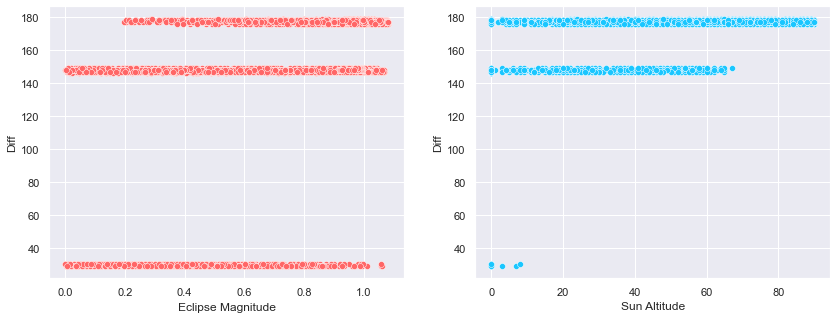

In [1425]:
fig,ax=plt.subplots(1,2,figsize=(14,5),squeeze=False)
sns.scatterplot( d['Eclipse Magnitude'],d['Diff'],ax = ax[0][0],color='#ff6666')
sns.scatterplot(d['Sun Altitude'],d['Diff'],ax = ax[0][1],color='#1ac6ff')


The consecutive time intervals are mainly taking th value less than 40 or between 140-180. Since it hasbetter correlation with Eclipse Magnitude and Sun Altitude, I tried to plot and see if there was any pattern. Instead we got to see that the time intervals are ot much varied.

In [1426]:
df = d.iloc[1:]
df

,Delta T (s),Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Time,Diff
1,46426.0,10.0,A,-0.2317,0.9382,32.9S,10.8E,76.0,21,236,06m44s,991261.5,176.0
2,46415.0,15.0,T,0.4994,1.0284,46.2N,83.4E,60.0,151,111,02m15s,991439.5,178.0
3,46403.0,20.0,A,-0.9045,0.9806,67.8S,143.8W,25.0,74,162,01m14s,991616.5,177.0
4,46393.0,-13.0,P,-1.4670,0.1611,60.6S,106.4W,0.0,281,NaN,NaN,991764.5,148.0
5,46391.0,25.0,P,1.3253,0.4035,61.7N,151.7W,0.0,55,NaN,NaN,991794.5,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9513,64.0,142.0,T,-0.3020,1.0244,39.5S,59.6E,72.0,16,87,02m04s,2452612.5,177.0
9514,64.0,147.0,An,0.9960,0.9384,66.6N,24.5W,3.0,35,-,03m37s,2452790.5,178.0
9515,64.0,152.0,T,-0.9638,1.0379,72.7S,88.4E,15.0,111,495,01m57s,2452966.5,176.0
9516,65.0,119.0,P,-1.1335,0.7367,61.6S,44.3E,0.0,295,NaN,NaN,2453114.5,148.0


### Eclipse Type analysis 

Unique Eclipse Type =  ['T' 'A' 'P' 'Pb' 'H' 'Pe' 'A+' 'H3' 'Hm' 'An' 'H2' 'Tm' 'Am' 'T+' 'A-'
 'T-' 'As' 'Tn' 'Ts']
Eclipse Type
Tm    177
Am    177
Hm    176
H3    176
H     175
H2    175
T     174
A     173
As    170
An    168
T-    165
A-    164
A+    163
T+    154
Pe    147
Tn    144
Ts    137
P     119
Pb     29
Name: Diff, dtype: int64


<AxesSubplot:xlabel='Eclipse Type', ylabel='Diff mode'>

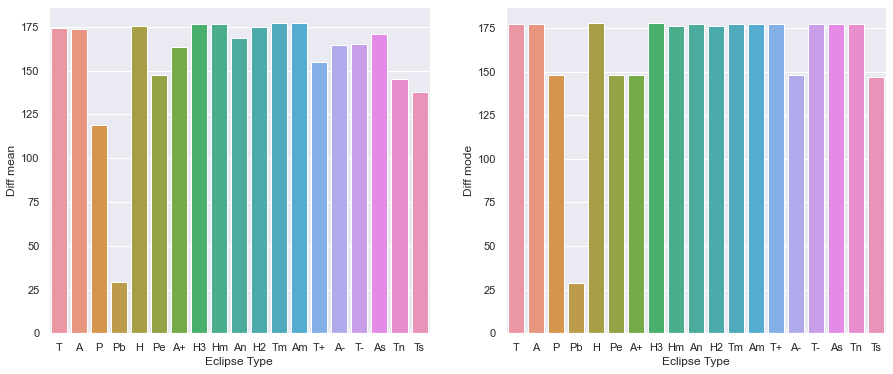

In [1427]:
sns.set_palette('CMRmap')
print("Unique Eclipse Type = ",d['Eclipse Type'].unique())
print(d.groupby('Eclipse Type')['Diff'].mean().apply(int).sort_values(ascending=False))
x=pd.DataFrame()
x['Eclipse Type'] = d['Eclipse Type']
x['Diff'] = d['Diff']
x['Diff mode'] = x['Eclipse Type'].map(x.groupby('Eclipse Type')['Diff'].apply(lambda y: list(y.mode())[0])) 
x['Diff mean'] = x['Eclipse Type'].map(x.groupby('Eclipse Type')['Diff'].mean())
fig,ax=plt.subplots(1,2,figsize=(15,6),squeeze=False)
sns.barplot(x['Eclipse Type'],x['Diff mean'],ax=ax[0][0])
sns.barplot(x['Eclipse Type'],x['Diff mode'],ax=ax[0][1])

We can encode the Eclipse type by its mean of Diff, because the mean and mode graphs are almot similar, and the consecutive intervals in encoding will give better results. <br>So, we mean encode the Eclipse type, and suppose if there is a missng value, or some value of eclipse type that is already not there in the train set, that is why we use a default dictionary where we return the mean value, in case there is data in test et that is already not present in train set.

In [1428]:
x = pd.DataFrame()
type_dict1 = dict()
type_dict1 =  (d.groupby('Eclipse Type')['Diff'].mean()).to_dict()
x['Eclipse Type']=d['Eclipse Type']
x['Eclipse Type'] = x['Eclipse Type'].map(type_dict1)
x['Eclipse Type'].mean()

153.64373904968693

In [1429]:
def def_value():
    return 153.64
type_dict = defaultdict(def_value)
for i,j in type_dict1.items():
    type_dict[i] = j
d['Eclipse Type'] = d['Eclipse Type'].map(type_dict)
test['Eclipse Type'] = test['Eclipse Type'].map(type_dict)

In [1430]:
d.corr()

,Delta T (s),Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Sun Altitude,Sun Azimuth,Time,Diff
Delta T (s),1.000000,-0.909183,-0.004368,-0.001723,-0.015550,-0.001337,0.002244,-0.962003,-0.015799
Saros Number,-0.909183,1.000000,-0.025483,-0.001173,0.011316,0.001339,-0.052533,0.947116,-0.101939
Eclipse Type,-0.004368,-0.025483,1.000000,-0.002325,0.806708,0.782529,0.012659,0.005830,0.637694
Gamma,-0.001723,-0.001173,-0.002325,1.000000,-0.000850,0.001777,-0.004172,0.001106,0.012282
Eclipse Magnitude,-0.015550,0.011316,0.806708,-0.000850,1.000000,0.692768,0.007746,0.013026,0.651991
Sun Altitude,-0.001337,0.001339,0.782529,0.001777,0.692768,1.000000,0.002026,0.001762,0.525735
Sun Azimuth,0.002244,-0.052533,0.012659,-0.004172,0.007746,0.002026,1.000000,-0.003455,0.025862
Time,-0.962003,0.947116,0.005830,0.001106,0.013026,0.001762,-0.003455,1.000000,0.013382
Diff,-0.015799,-0.101939,0.637694,0.012282,0.651991,0.525735,0.025862,0.013382,1.000000


### Time interval(Diff column) analysis

(array([1080.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 1864.,  323.,    0.,    0.,    0., 6250.]),
 array([ 29.,  35.,  41.,  47.,  53.,  59.,  65.,  71.,  77.,  83.,  89.,
         95., 101., 107., 113., 119., 125., 131., 137., 143., 149., 155.,
        161., 167., 173., 179.]),
 <BarContainer object of 25 artists>)

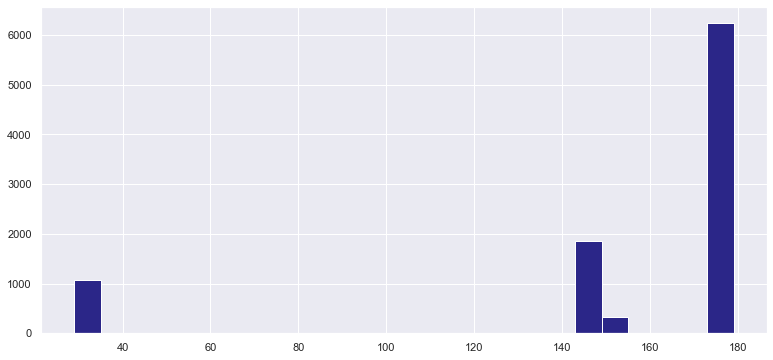

In [1431]:
fig,ax=plt.subplots(1,1,figsize=(13,6),squeeze=False)
plt.hist(d['Diff'],bins=25)

The most frequent difference is around 170 ro 180. So, we can take that as the mode, and we can do our outlier analysis, with a boxplot, but first lets look at the cumulative distribution.

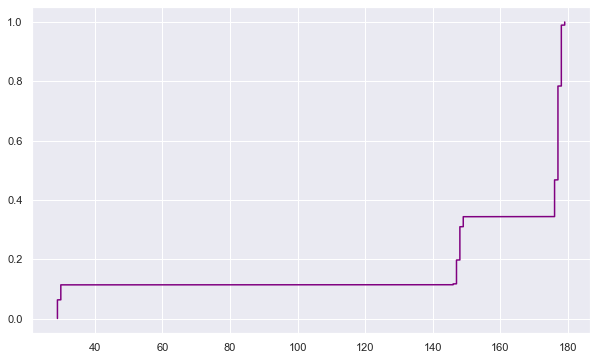

In [1432]:
fig,ax=plt.subplots(1,1,figsize=(10,6),squeeze=False)
ecdf = ECDF(d['Diff'])
plt.plot(ecdf.x, ecdf.y, color='purple')
plt.show()

This cumulative distribution plot mainly is used to see what percent of data is les than a particular value. Here it shows that 100% of the data is less that 180. 80% of the data is less than around 175-180. So, we now for a fact know that anything beyond that will be an outlier, and if any prediction comes beyond that range, then it's incorrect. 

In [1433]:
d

,Delta T (s),Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Time,Diff
0,NaN,NaN,174.108275,NaN,NaN,6.0N,33.3W,NaN,344,247,06m37s,991085.5,NaN
1,46426.0,10.0,173.492759,-0.2317,0.9382,32.9S,10.8E,76.0,21,236,06m44s,991261.5,176.0
2,46415.0,15.0,174.108275,0.4994,1.0284,46.2N,83.4E,60.0,151,111,02m15s,991439.5,178.0
3,46403.0,20.0,173.492759,-0.9045,0.9806,67.8S,143.8W,25.0,74,162,01m14s,991616.5,177.0
4,46393.0,-13.0,119.026154,-1.4670,0.1611,60.6S,106.4W,0.0,281,NaN,NaN,991764.5,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9513,64.0,142.0,174.108275,-0.3020,1.0244,39.5S,59.6E,72.0,16,87,02m04s,2452612.5,177.0
9514,64.0,147.0,168.880000,0.9960,0.9384,66.6N,24.5W,3.0,35,-,03m37s,2452790.5,178.0
9515,64.0,152.0,174.108275,-0.9638,1.0379,72.7S,88.4E,15.0,111,495,01m57s,2452966.5,176.0
9516,65.0,119.0,119.026154,-1.1335,0.7367,61.6S,44.3E,0.0,295,NaN,NaN,2453114.5,148.0


### Saros Number Normal Distribution and Mode Imputation

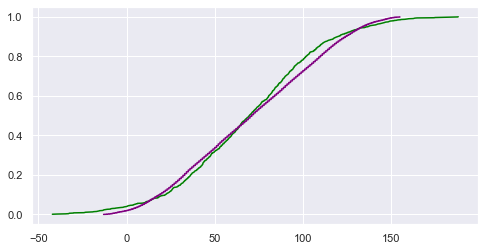

In [1434]:
fig,ax=plt.subplots(1,1,figsize=(8,4),squeeze=False)
s = np.std(d['Saros Number'])
m = np.mean(d['Saros Number'])
sample = np.random.normal(m, s, size=1000)
e1 = ECDF(sample)
e2 = ECDF(d['Saros Number'])
plt.plot(e1.x, e1.y, color='green')
plt.plot(e2.x, e2.y, color='purple')
plt.show()

We first got the  the mean and standard deviation of the Saros Number, and then produced a sample which will have normal distribution over 1000 such iterations. Now, to check if Saros Number follows the normal distribution we plot the ECDF plot basically the cumulative distribution of the theoretical normal distribution and the actual distribution. They almost coincide, so we won't change the Saros Nuber.

We can do mode imputation for the Saros Number

In [1435]:
d['Saros Number'].fillna(d['Saros Number'].mode()[0], inplace=True)
test['Saros Number'].fillna(d['Saros Number'].mode()[0], inplace=True)

In [1436]:
d.corr()

,Delta T (s),Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Sun Altitude,Sun Azimuth,Time,Diff
Delta T (s),1.000000,-0.909183,-0.004368,-0.001723,-0.015550,-0.001337,0.002244,-0.962003,-0.015799
Saros Number,-0.909183,1.000000,-0.025761,-0.001223,0.011212,0.001400,-0.052702,0.946215,-0.101802
Eclipse Type,-0.004368,-0.025761,1.000000,-0.002325,0.806708,0.782529,0.012659,0.005830,0.637694
Gamma,-0.001723,-0.001223,-0.002325,1.000000,-0.000850,0.001777,-0.004172,0.001106,0.012282
Eclipse Magnitude,-0.015550,0.011212,0.806708,-0.000850,1.000000,0.692768,0.007746,0.013026,0.651991
Sun Altitude,-0.001337,0.001400,0.782529,0.001777,0.692768,1.000000,0.002026,0.001762,0.525735
Sun Azimuth,0.002244,-0.052702,0.012659,-0.004172,0.007746,0.002026,1.000000,-0.003455,0.025862
Time,-0.962003,0.946215,0.005830,0.001106,0.013026,0.001762,-0.003455,1.000000,0.013382
Diff,-0.015799,-0.101802,0.637694,0.012282,0.651991,0.525735,0.025862,0.013382,1.000000


### Delta T (s) Analysis (Yeo Johnson transformation and Imputation)

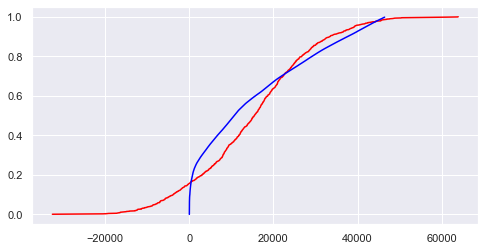

In [1437]:
fig,ax=plt.subplots(1,1,figsize=(8,4),squeeze=False)
s = np.std(d['Delta T (s)'])
m = np.mean(d['Delta T (s)'])
sample = np.random.normal(m, s, size=1000)
e1 = ECDF(sample)
e2 = ECDF(d['Delta T (s)'])
plt.plot(e1.x, e1.y, color='red')
plt.plot(e2.x, e2.y, color='blue')
plt.show()

We can clearly see that Delta T(s) does not follow the normal distribuion. So, we shall use log transformation to convert this

In [1438]:
d[d['Delta T (s)'].isnull()]

,Delta T (s),Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Time,Diff
0,NaN,34.0,174.108275,NaN,NaN,6.0N,33.3W,NaN,344,247,06m37s,991085.5,NaN
500,NaN,12.0,173.492759,-0.1047,0.9509,29.0S,73.7W,84.0,358,181,05m49s,1065089.5,179.0
1000,NaN,34.0,173.492759,0.7568,0.9516,65.7N,23.0E,41.0,138,271,03m51s,1140834.5,177.0
1500,NaN,10.0,119.026154,1.1072,0.8055,64.3N,136.3W,0.0,205,NaN,NaN,1221748.5,148.0
2000,NaN,34.0,173.492759,-0.6788,NaN,19.9S,83.6E,47.0,1,189,04m46s,1296106.5,178.0
2500,NaN,56.0,119.026154,-1.1814,0.6476,62.5S,59.6W,0.0,135,NaN,NaN,1372206.5,177.0
3000,NaN,34.0,119.026154,NaN,0.4652,64.0N,147.3E,0.0,209,NaN,NaN,1452943.5,148.0
3500,NaN,63.0,174.108275,0.5735,1.0387,18.0N,102.1W,NaN,192,158,03m36s,1525233.5,176.0
4000,NaN,34.0,119.026154,1.1063,NaN,68.1N,90.5E,0.0,346,NaN,NaN,1602190.5,29.0
4500,NaN,84.0,119.026154,-1.1974,0.6312,68.4S,59.1E,0.0,344,NaN,NaN,1681391.5,29.0


In [1439]:
print(d['Delta T (s)'].mode())
print(np.mean(d['Delta T (s)']))

0    12.0
dtype: float64
14739.58780795957


Sinc the mode and mean of the Delta T (s) vary by a great deal, well look at the boxplot for its outliers and then decide whether to do mean or mode imputation

<AxesSubplot:xlabel='Delta T (s)'>

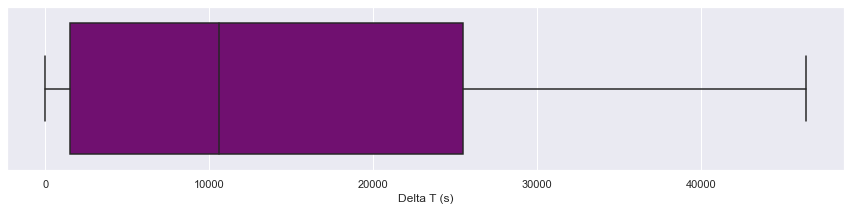

In [1440]:
fig,ax=plt.subplots(figsize=(15,3))
sns.boxplot(x=d['Delta T (s)'],color='purple')

(array([2657.,  644.,  571.,  547.,  573.,  442.,  357.,  366.,  365.,
         314.,  295.,  306.,  304.,  278.,  254.,  241.,  244.,  257.,
         250.,  233.]),
 array([-6.00000e+00,  2.31560e+03,  4.63720e+03,  6.95880e+03,
         9.28040e+03,  1.16020e+04,  1.39236e+04,  1.62452e+04,
         1.85668e+04,  2.08884e+04,  2.32100e+04,  2.55316e+04,
         2.78532e+04,  3.01748e+04,  3.24964e+04,  3.48180e+04,
         3.71396e+04,  3.94612e+04,  4.17828e+04,  4.41044e+04,
         4.64260e+04]),
 <BarContainer object of 20 artists>)

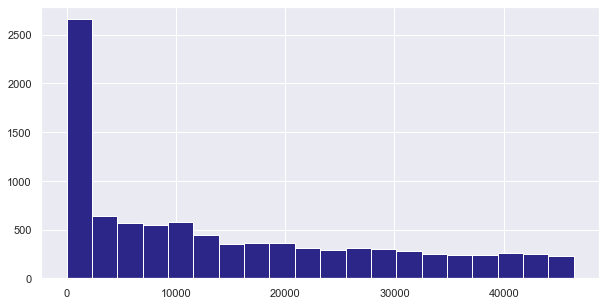

In [1441]:
fig,ax=plt.subplots(figsize=(10,5))
plt.hist(d['Delta T (s)'], bins=20)

We shall do mode imputation, since most of the data lies in the smaller range for Delta T(s)

In [1442]:
d['Delta T (s)'].fillna(d['Delta T (s)'].mode()[0], inplace=True)
test['Delta T (s)'].fillna(d['Delta T (s)'].mode()[0], inplace=True)

Since it has negative values BoxCox transformation cannot be applied to change it to normal distribuion, so instead we'll use Yeo Johnson Transformer

In [1443]:
tf = vt.YeoJohnsonTransformer(variables = ['Delta T (s)'])
tf.fit(d)
d= tf.transform(d)
test= tf.transform(test)

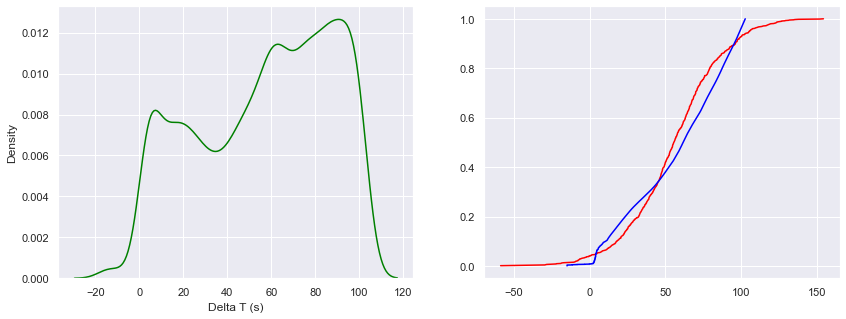

In [1444]:
fig,ax=plt.subplots(1,2,figsize=(14,5),squeeze=False)
sns.kdeplot(d['Delta T (s)'],ax=ax[0][0], color='green')
s = np.std(d['Delta T (s)'])
m = np.mean(d['Delta T (s)'])
sample = np.random.normal(m, s, size=1000)
e1 = ECDF(sample)
e2 = ECDF(d['Delta T (s)'])
plt.plot(e1.x, e1.y, color='red')
plt.plot(e2.x, e2.y, color='blue')
plt.show()

In [1445]:
d.corr()

,Delta T (s),Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Sun Altitude,Sun Azimuth,Time,Diff
Delta T (s),1.000000,-0.933088,-0.005786,-0.001516,-0.010135,-0.001387,0.002490,-0.985875,-0.010169
Saros Number,-0.933088,1.000000,-0.025761,-0.001223,0.011212,0.001400,-0.052702,0.946215,-0.101802
Eclipse Type,-0.005786,-0.025761,1.000000,-0.002325,0.806708,0.782529,0.012659,0.005830,0.637694
Gamma,-0.001516,-0.001223,-0.002325,1.000000,-0.000850,0.001777,-0.004172,0.001106,0.012282
Eclipse Magnitude,-0.010135,0.011212,0.806708,-0.000850,1.000000,0.692768,0.007746,0.013026,0.651991
Sun Altitude,-0.001387,0.001400,0.782529,0.001777,0.692768,1.000000,0.002026,0.001762,0.525735
Sun Azimuth,0.002490,-0.052702,0.012659,-0.004172,0.007746,0.002026,1.000000,-0.003455,0.025862
Time,-0.985875,0.946215,0.005830,0.001106,0.013026,0.001762,-0.003455,1.000000,0.013382
Diff,-0.010169,-0.101802,0.637694,0.012282,0.651991,0.525735,0.025862,0.013382,1.000000


### Gamma Analysis

(array([400., 548., 460., 478., 490., 485., 486., 449., 477., 476., 484.,
        473., 459., 458., 508., 488., 449., 514., 455., 465.]),
 array([-1.569 , -1.4123, -1.2556, -1.0989, -0.9422, -0.7855, -0.6288,
        -0.4721, -0.3154, -0.1587, -0.002 ,  0.1547,  0.3114,  0.4681,
         0.6248,  0.7815,  0.9382,  1.0949,  1.2516,  1.4083,  1.565 ]),
 <BarContainer object of 20 artists>)

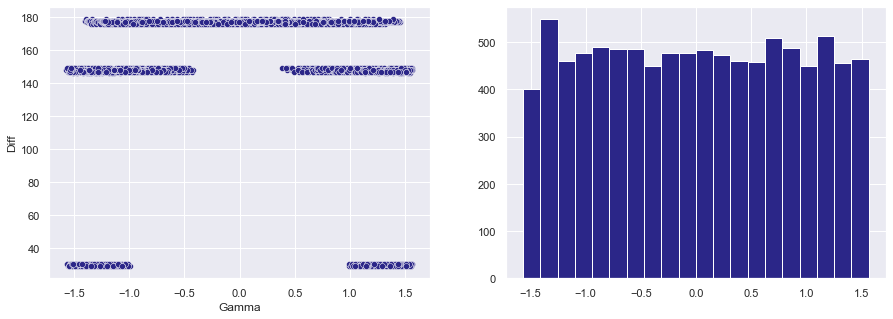

In [1446]:
fig,ax=plt.subplots(1,2,figsize=(15,5),squeeze=False)
sns.scatterplot(d['Gamma'],d['Diff'],ax=ax[0][0])
plt.hist(d['Gamma'], bins=20)

We can see that all bins of these values of Gamma are almost equally used, tha every bin has almost similar participation. Looking further into the data, it has 8122 unique values, the model won't be able to learn much from this column. Because every bin has almost the same contribution, and it has 90% of the data unique so we can drop the column Gamma, also it has poor correlation with the Time interval.

In [1447]:
len(d['Gamma'].unique())

8122

In [1448]:
d.drop(columns=['Gamma'],inplace=True)
test.drop(columns=['Gamma'],inplace=True)

In [1449]:
d

,Delta T (s),Saros Number,Eclipse Type,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Time,Diff
0,4.038659,34.0,174.108275,NaN,6.0N,33.3W,NaN,344,247,06m37s,991085.5,NaN
1,102.658411,10.0,173.492759,0.9382,32.9S,10.8E,76.0,21,236,06m44s,991261.5,176.0
2,102.650129,15.0,174.108275,1.0284,46.2N,83.4E,60.0,151,111,02m15s,991439.5,178.0
3,102.641092,20.0,173.492759,0.9806,67.8S,143.8W,25.0,74,162,01m14s,991616.5,177.0
4,102.633560,-13.0,119.026154,0.1611,60.6S,106.4W,0.0,281,NaN,NaN,991764.5,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9513,9.002338,142.0,174.108275,1.0244,39.5S,59.6E,72.0,16,87,02m04s,2452612.5,177.0
9514,9.002338,147.0,168.880000,0.9384,66.6N,24.5W,3.0,35,-,03m37s,2452790.5,178.0
9515,9.002338,152.0,174.108275,1.0379,72.7S,88.4E,15.0,111,495,01m57s,2452966.5,176.0
9516,9.063217,119.0,119.026154,0.7367,61.6S,44.3E,0.0,295,NaN,NaN,2453114.5,148.0


### Eclipse Magnitude Analysis, Imputation and Discretization

(array([ 369.,  388.,  381.,  396.,  374.,  370.,  386.,  360., 2629.,
        3841.]),
 array([0.     , 0.10813, 0.21626, 0.32439, 0.43252, 0.54065, 0.64878,
        0.75691, 0.86504, 0.97317, 1.0813 ]),
 <BarContainer object of 10 artists>)

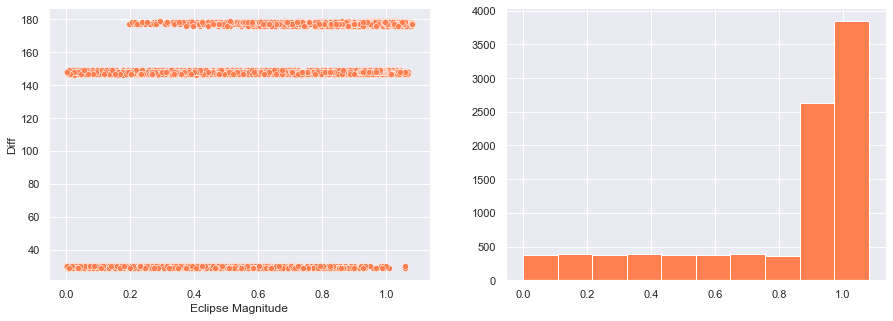

In [1450]:
fig,ax=plt.subplots(1,2,figsize=(15,5),squeeze=False)
sns.scatterplot(d['Eclipse Magnitude'],d['Diff'],ax=ax[0][0],color='coral')
plt.hist(d['Eclipse Magnitude'], bins=10,color='coral')

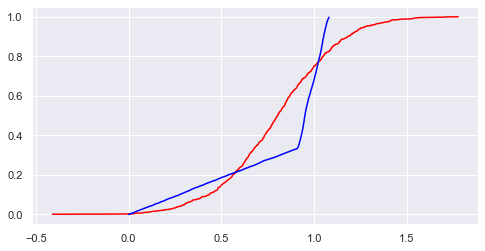

In [1451]:
fig,ax=plt.subplots(1,1,figsize=(8,4),squeeze=False)
s = np.std(d['Eclipse Magnitude'])
m = np.mean(d['Eclipse Magnitude'])
sample = np.random.normal(m, s, size=1000)
e1 = ECDF(sample)
e2 = ECDF(d['Eclipse Magnitude'])
plt.plot(e1.x, e1.y, color='red')
plt.plot(e2.x, e2.y, color='blue')
plt.show()

So, it is not normally distributed. Also, we can discretiz eclipse magnitude to have better correlation with the Time interval. We can use the feature engine Equal width discretizer to divide the data into equal sized bins, and see the new correlation. <br>
Also, we will do mode imputation

In [1452]:
print(np.mean(d['Eclipse Magnitude']))
print(d['Eclipse Magnitude'].mode())

0.8134463871919089
0    0.9481
dtype: float64


In [1453]:
d['Eclipse Magnitude'].fillna(d['Eclipse Magnitude'].mode()[0], inplace=True)
test['Eclipse Magnitude'].fillna(d['Eclipse Magnitude'].mode()[0], inplace=True)

In [1454]:
disc = EqualWidthDiscretiser(bins=10, variables=['Eclipse Magnitude'])
disc.fit(d)
d= disc.transform(d)
test= disc.transform(test)

Eclipse Magnitude
9    173
8    171
7    147
6    136
5    126
4    115
3    100
2     96
1     89
0     89
Name: Diff, dtype: int64


<AxesSubplot:xlabel='Eclipse Magnitude', ylabel='Diff mode'>

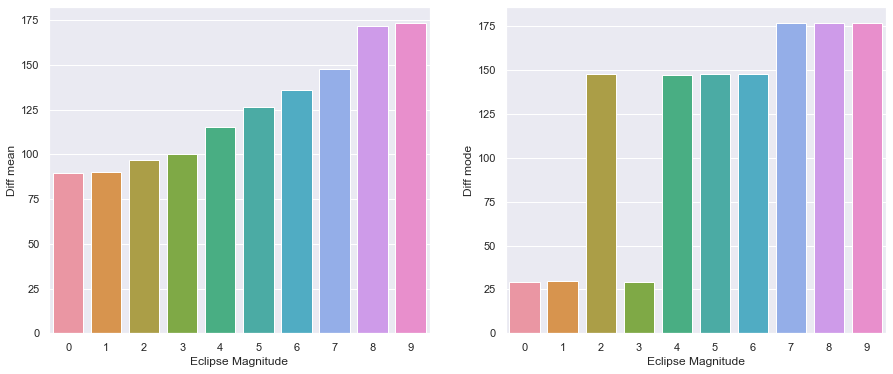

In [1455]:
sns.set_palette('CMRmap')
print(d.groupby('Eclipse Magnitude')['Diff'].mean().apply(int).sort_values(ascending=False))
x=pd.DataFrame()
x['Eclipse Magnitude'] = d['Eclipse Magnitude']
x['Diff'] = d['Diff']
x['Diff mode'] = x['Eclipse Magnitude'].map(x.groupby('Eclipse Magnitude')['Diff'].apply(lambda y: list(y.mode())[0])) 
x['Diff mean'] = x['Eclipse Magnitude'].map(x.groupby('Eclipse Magnitude')['Diff'].mean())
fig,ax=plt.subplots(1,2,figsize=(15,6),squeeze=False)
sns.barplot(x['Eclipse Magnitude'],x['Diff mean'],ax=ax[0][0])
sns.barplot(x['Eclipse Magnitude'],x['Diff mode'],ax=ax[0][1])

In [1456]:
d.corr()

,Delta T (s),Saros Number,Eclipse Type,Eclipse Magnitude,Sun Altitude,Sun Azimuth,Time,Diff
Delta T (s),1.000000,-0.933088,-0.005786,-0.010196,-0.001387,0.002490,-0.985875,-0.010169
Saros Number,-0.933088,1.000000,-0.025761,0.010508,0.001400,-0.052702,0.946215,-0.101802
Eclipse Type,-0.005786,-0.025761,1.000000,0.798878,0.782529,0.012659,0.005830,0.637694
Eclipse Magnitude,-0.010196,0.010508,0.798878,1.000000,0.682703,0.006148,0.012943,0.648557
Sun Altitude,-0.001387,0.001400,0.782529,0.682703,1.000000,0.002026,0.001762,0.525735
Sun Azimuth,0.002490,-0.052702,0.012659,0.006148,0.002026,1.000000,-0.003455,0.025862
Time,-0.985875,0.946215,0.005830,0.012943,0.001762,-0.003455,1.000000,0.013382
Diff,-0.010169,-0.101802,0.637694,0.648557,0.525735,0.025862,0.013382,1.000000


### Sun Altitude analysis

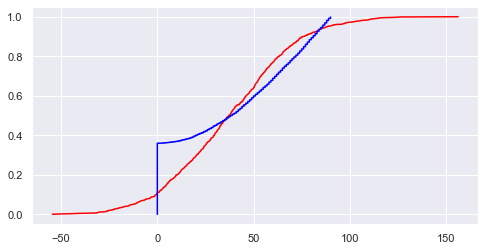

In [1457]:
fig,ax=plt.subplots(1,1,figsize=(8,4),squeeze=False)
s = np.std(d['Sun Altitude'])
m = np.mean(d['Sun Altitude'])
sample = np.random.normal(m, s, size=1000)
e1 = ECDF(sample)
e2 = ECDF(d['Sun Altitude'])
plt.plot(e1.x, e1.y, color='red')
plt.plot(e2.x, e2.y, color='blue')
plt.show()

It does not follow normal distribution, so we can transform it. 

In [1458]:
print(d['Sun Altitude'].mode())
print(np.mean(d['Sun Altitude']))

0    0.0
dtype: float64
36.513468013468014


(array([3491.,  192.,  397.,  488.,  633.,  736.,  811.,  832.,  922.,
        1002.]),
 array([ 0.,  9., 18., 27., 36., 45., 54., 63., 72., 81., 90.]),
 <BarContainer object of 10 artists>)

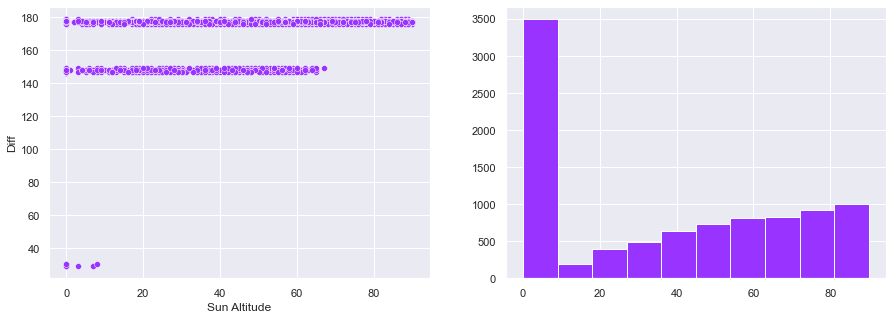

In [1459]:
fig,ax=plt.subplots(1,2,figsize=(15,5),squeeze=False)
sns.scatterplot(d['Sun Altitude'],d['Diff'],ax=ax[0][0],color='#9933ff')
plt.hist(d['Sun Altitude'], bins=10,color='#9933ff')

Again, we can do mode imputations to fill the missing values

In [1460]:
d['Sun Altitude'].fillna(d['Sun Altitude'].mode()[0], inplace=True)
test['Sun Altitude'].fillna(d['Sun Altitude'].mode()[0], inplace=True)

### Sun Azimuth analysis

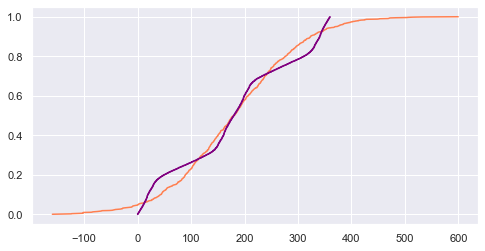

In [1461]:
fig,ax=plt.subplots(1,1,figsize=(8,4),squeeze=False)
s = np.std(d['Sun Azimuth'])
m = np.mean(d['Sun Azimuth'])
sample = np.random.normal(m, s, size=1000)
e1 = ECDF(sample)
e2 = ECDF(d['Sun Azimuth'])
plt.plot(e1.x, e1.y, color='coral')
plt.plot(e2.x, e2.y, color='purple')
plt.show()

(array([1639.,  535.,  420.,  506., 1643., 1635.,  515.,  433.,  519.,
        1673.]),
 array([  0.,  36.,  72., 108., 144., 180., 216., 252., 288., 324., 360.]),
 <BarContainer object of 10 artists>)

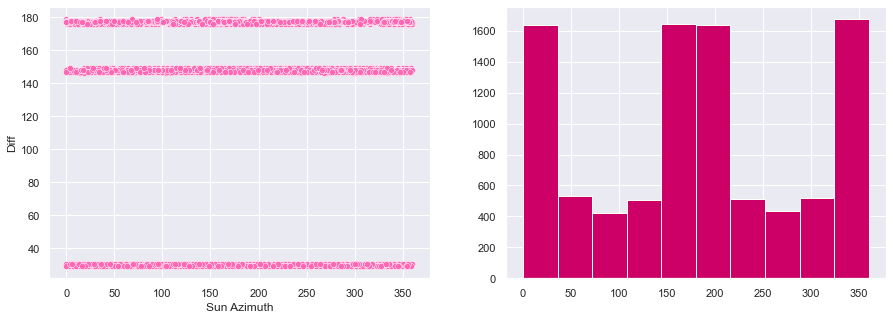

In [1462]:
fig,ax=plt.subplots(1,2,figsize=(15,5),squeeze=False)
sns.scatterplot(d['Sun Azimuth'],d['Diff'],ax=ax[0][0],color='#ff66b3')
plt.hist(d['Sun Azimuth'], bins=10,color='#cc0066')

In [1463]:
d

,Delta T (s),Saros Number,Eclipse Type,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Time,Diff
0,4.038659,34.0,174.108275,8,6.0N,33.3W,0.0,344,247,06m37s,991085.5,NaN
1,102.658411,10.0,173.492759,8,32.9S,10.8E,76.0,21,236,06m44s,991261.5,176.0
2,102.650129,15.0,174.108275,9,46.2N,83.4E,60.0,151,111,02m15s,991439.5,178.0
3,102.641092,20.0,173.492759,9,67.8S,143.8W,25.0,74,162,01m14s,991616.5,177.0
4,102.633560,-13.0,119.026154,1,60.6S,106.4W,0.0,281,NaN,NaN,991764.5,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9513,9.002338,142.0,174.108275,9,39.5S,59.6E,72.0,16,87,02m04s,2452612.5,177.0
9514,9.002338,147.0,168.880000,8,66.6N,24.5W,3.0,35,-,03m37s,2452790.5,178.0
9515,9.002338,152.0,174.108275,9,72.7S,88.4E,15.0,111,495,01m57s,2452966.5,176.0
9516,9.063217,119.0,119.026154,6,61.6S,44.3E,0.0,295,NaN,NaN,2453114.5,148.0


### Path Width Analysis

In [1464]:
d['Path Width (km)'].isnull().sum()

3355

Since many null values are present, it'll be inappropriate to do so many null imputations. Instead we'll drop the column, since much information cannot be derived from Path width.

In [1465]:
d.drop(columns=['Path Width (km)'],inplace=True)
test.drop(columns=['Path Width (km)'],inplace=True)

In [1466]:
d

,Delta T (s),Saros Number,Eclipse Type,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Central Duration,Time,Diff
0,4.038659,34.0,174.108275,8,6.0N,33.3W,0.0,344,06m37s,991085.5,NaN
1,102.658411,10.0,173.492759,8,32.9S,10.8E,76.0,21,06m44s,991261.5,176.0
2,102.650129,15.0,174.108275,9,46.2N,83.4E,60.0,151,02m15s,991439.5,178.0
3,102.641092,20.0,173.492759,9,67.8S,143.8W,25.0,74,01m14s,991616.5,177.0
4,102.633560,-13.0,119.026154,1,60.6S,106.4W,0.0,281,NaN,991764.5,148.0
...,...,...,...,...,...,...,...,...,...,...,...
9513,9.002338,142.0,174.108275,9,39.5S,59.6E,72.0,16,02m04s,2452612.5,177.0
9514,9.002338,147.0,168.880000,8,66.6N,24.5W,3.0,35,03m37s,2452790.5,178.0
9515,9.002338,152.0,174.108275,9,72.7S,88.4E,15.0,111,01m57s,2452966.5,176.0
9516,9.063217,119.0,119.026154,6,61.6S,44.3E,0.0,295,NaN,2453114.5,148.0


### Central Duration Analysis

In [1467]:
d['Central Duration'].isnull().sum()

3355

 Since many null values are present, it'll be inappropriate to do so many null imputations. Instead we'll drop the column, since much information cannot be derived

In [1468]:
d.drop(columns=['Central Duration'],inplace=True)
test.drop(columns=['Central Duration'],inplace=True)

### Longitude and Latitude

These two columns also do not give us any special information about the eclipse timing. It is the longitude and the latitude of where the greatest eclipse can be seen, so we can drop this too.

In [1469]:
d.drop(columns=['Longitude'],inplace=True)
test.drop(columns=['Longitude'],inplace=True)
d.drop(columns=['Latitude'],inplace=True)
test.drop(columns=['Latitude'],inplace=True)

### Julian Day Analysis

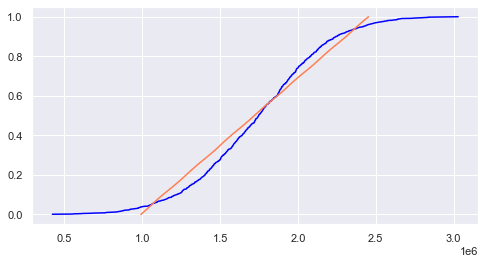

In [1470]:
fig,ax=plt.subplots(1,1,figsize=(8,4),squeeze=False)
s = np.std(d['Time'])
m = np.mean(d['Time'])
sample = np.random.normal(m, s, size=1000)
e1 = ECDF(sample)
e2 = ECDF(d['Time'])
plt.plot(e1.x, e1.y, color='blue')
plt.plot(e2.x, e2.y, color='coral')
plt.show()

In [1471]:
d[d['Time']<=0]

,Delta T (s),Saros Number,Eclipse Type,Eclipse Magnitude,Sun Altitude,Sun Azimuth,Time,Diff


In [1472]:
d['Time normal'] = np.log(d['Time'])
test['Time normal'] = np.log(test['Time'])

In [1473]:
d.corr()

,Delta T (s),Saros Number,Eclipse Type,Eclipse Magnitude,Sun Altitude,Sun Azimuth,Time,Diff,Time normal
Delta T (s),1.000000,-0.933088,-0.005786,-0.010196,-0.000740,0.002490,-0.985875,-0.010169,-0.965655
Saros Number,-0.933088,1.000000,-0.025761,0.010508,0.001611,-0.052702,0.946215,-0.101802,0.939086
Eclipse Type,-0.005786,-0.025761,1.000000,0.798878,0.780750,0.012659,0.005830,0.637694,0.005378
Eclipse Magnitude,-0.010196,0.010508,0.798878,1.000000,0.681372,0.006148,0.012943,0.648557,0.014458
Sun Altitude,-0.000740,0.001611,0.780750,0.681372,1.000000,0.001672,0.001885,0.525112,0.001751
Sun Azimuth,0.002490,-0.052702,0.012659,0.006148,0.001672,1.000000,-0.003455,0.025862,-0.003098
Time,-0.985875,0.946215,0.005830,0.012943,0.001885,-0.003455,1.000000,0.013382,0.993324
Diff,-0.010169,-0.101802,0.637694,0.648557,0.525112,0.025862,0.013382,1.000000,0.014612
Time normal,-0.965655,0.939086,0.005378,0.014458,0.001751,-0.003098,0.993324,0.014612,1.000000


In [1474]:
test1 = test[1:]
df = d[1:]

### Forward Selection 

In [1475]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

i=8
while i!=0:
    sfs = SFS(LinearRegression(),
          k_features=i,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)
    sfs.fit(df[['Delta T (s)','Saros Number','Eclipse Type', 'Eclipse Magnitude','Sun Altitude', 'Sun Azimuth','Time', 'Time normal']],df['Diff'])
    print(sfs.k_feature_names_ )
    i=i-1

('Delta T (s)', 'Saros Number', 'Eclipse Type', 'Eclipse Magnitude', 'Sun Altitude', 'Sun Azimuth', 'Time', 'Time normal')
('Delta T (s)', 'Saros Number', 'Eclipse Type', 'Eclipse Magnitude', 'Sun Altitude', 'Sun Azimuth', 'Time')
('Saros Number', 'Eclipse Type', 'Eclipse Magnitude', 'Sun Altitude', 'Sun Azimuth', 'Time')
('Saros Number', 'Eclipse Type', 'Eclipse Magnitude', 'Sun Altitude', 'Time')
('Saros Number', 'Eclipse Type', 'Eclipse Magnitude', 'Time')
('Saros Number', 'Eclipse Type', 'Eclipse Magnitude')
('Eclipse Type', 'Eclipse Magnitude')
('Eclipse Magnitude',)


### Decision Tree 

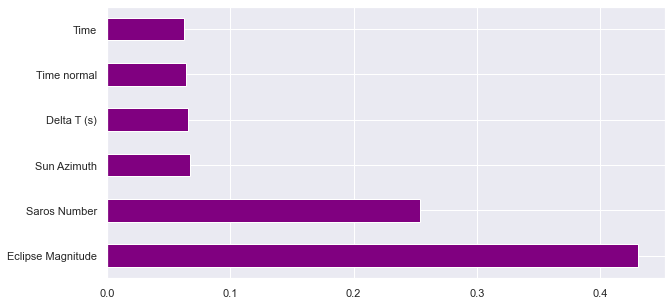

In [1476]:
fig,ax=plt.subplots(1,1,figsize=(10,5),squeeze=False)
def tree_based_feature_importance(x_train,y_train):
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=120)
    model.fit(x_train, y_train)
    importances = model.feature_importances_
    final_df = pd.DataFrame({"Features": x_train.columns, "Importances":importances})
    final_df.set_index('Importances')
    final_df = final_df.sort_values('Importances',ascending=False)
    pd.Series(model.feature_importances_, index=x_train.columns).nlargest(6).plot(kind='barh',color='purple')  
    return final_df
X_train = df[['Delta T (s)','Saros Number','Eclipse Type', 'Eclipse Magnitude','Sun Altitude', 'Sun Azimuth','Time', 'Time normal']]
Y_train = df[['Diff']]
feature_importance=tree_based_feature_importance(X_train,Y_train)

### Scaling & Fitting

In [1477]:
X_train = df[['Delta T (s)','Saros Number','Eclipse Type', 'Eclipse Magnitude','Sun Altitude', 'Sun Azimuth','Time','Time normal']]
Y_train = df[['Diff']]
X_test = test1[['Delta T (s)','Saros Number','Eclipse Type', 'Eclipse Magnitude','Sun Altitude', 'Sun Azimuth','Time','Time normal']]
Y_test = test1[['Diff']]


In [1478]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(Y_train)
X_train = scalerX.transform(X_train)
Y_train = scalery.transform(Y_train)
X_test = scalerX.transform(X_test)
Y_test = scalery.transform(Y_test)

In [1479]:
len(X_train)

9517

### Linear Regression

In [1480]:
def model_fit(model,X_train, Y_train):
    model = LinearRegression() 
    model.fit(X_train, Y_train)
    return model
lin_model = model_fit(LinearRegression,X_train, Y_train)

R2=list()
mse=list()
abse=list()
rm=list()
def scores_(model,X,Y):
    y_predict = model.predict(X)
    rmse = (np.sqrt(mean_squared_error(Y, y_predict)))
    r2 = r2_score(Y, y_predict)
    #print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print('Mean Absolute Error:', mean_absolute_error(Y, y_predict))  
    print('Mean Squared Error:', mean_squared_error(Y, y_predict))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y, y_predict)))
    print("Score: ",lin_model.score(X_test, Y_test))
    R2.append(r2)
    mse.append(mean_squared_error(Y, y_predict))
    abse.append(mean_absolute_error(Y, y_predict))
    rm.append(np.sqrt(mean_squared_error(Y, y_predict)))
score = scores_(lin_model, X_test, Y_test)

R2 score is 0.5211062942103344
Mean Absolute Error: 0.48898648569371644
Mean Squared Error: 0.49405938531171195
Root Mean Squared Error: 0.7028935803602931
Score:  0.5211062942103344


### SVM Regression

In [1481]:
regressor = SVR(kernel = 'linear',gamma=2)
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
y_predicted_val = y_pred
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))
print("Score: ",regressor.score(X_test, Y_test))

R2 score is 0.45423492440758406
Mean Absolute Error: 0.4052713683175952
Mean Squared Error: 0.5630484479372494
Root Mean Squared Error: 0.7503655428771029
Score:  0.45423492440758406


### Decision Tree Regression

In [1482]:
clf = DecisionTreeRegressor()
clf = clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is -0.35958295386127026
Mean Absolute Error: 0.5565246364788252
Mean Squared Error: 1.402638435928836
Root Mean Squared Error: 1.1843303744854456


### Random Forest Regression

In [1483]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train, Y_train);
y_pred = rf.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is 0.5686463119652665
Mean Absolute Error: 0.3590762144631619
Mean Squared Error: 0.4450138629635323
Root Mean Squared Error: 0.6670935938558639


### Gradient Boost

In [1484]:
clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=3)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is -0.04112634272249127
Mean Absolute Error: 0.7942887435025238
Mean Squared Error: 1.074096891854378
Root Mean Squared Error: 1.0363864587374625


### XG Boost

In [1485]:
clf = xgb.XGBRegressor()
clf.fit(X_train, Y_train)
predicted = clf.predict(X_test)

rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is -0.04112634272249127
Mean Absolute Error: 0.7942887435025238
Mean Squared Error: 1.074096891854378
Root Mean Squared Error: 1.0363864587374625


### Ridge Regression

In [1486]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is 0.5408105857108304
Mean Absolute Error: 0.47564509913324
Mean Squared Error: 0.473731095277736
Root Mean Squared Error: 0.6882812617511361


In [1487]:
errors=pd.DataFrame()
errors={'Algorithm':['Linear Regression','SVM','Decision Tree','Random Forest','Gradient Boost','XGBoost','Ridge Regression'],'Mean_Abs_Error':abse,'MSE':mse, 'RMSE':rm, 'R2':R2}
errors = pd.DataFrame(errors)
errors.sort_values(by='RMSE', ascending=True,inplace=True)
errors

,Algorithm,Mean_Abs_Error,MSE,RMSE,R2
3,Random Forest,0.359076,0.445014,0.667094,0.568646
6,Ridge Regression,0.475645,0.473731,0.688281,0.540811
0,Linear Regression,0.488986,0.494059,0.702894,0.521106
1,SVM,0.405271,0.563048,0.750366,0.454235
4,Gradient Boost,0.794289,1.074097,1.036386,-0.041126
5,XGBoost,0.794289,1.074097,1.036386,-0.041126
2,Decision Tree,0.556525,1.402638,1.184330,-0.359583


### Dropping columns

From Backward selection and decision tree, we see that <b>Delta T(s)</b> is of very les importance. We can drop it. ALso, since it has high correlation with Time, it'll create some wrong predictions, and also has very low correlation with the Time interval(Diff).

In [1488]:
df.drop(columns=['Delta T (s)'],inplace=True)
test1.drop(columns=['Delta T (s)'],inplace=True)

<b>Sun Azimuth</b> has very low correlation with the target varable, so we shall drop it too.

In [1489]:
df.drop(columns=['Sun Azimuth'],inplace=True)
test1.drop(columns=['Sun Azimuth'],inplace=True)

<b>Time</b> has high correlation with <b>Time normal</b>, since Time normal is the normalized version of Time, so we candrop Time. I'll not use Time as a feature, but I'll keep it if it's required for date calculation

### Scaling ad fitting(2)

In [1490]:
X_train = df[['Saros Number','Eclipse Type', 'Eclipse Magnitude','Sun Altitude', 'Time normal']]
Y_train = df[['Diff']]
X_test = test1[['Saros Number','Eclipse Type', 'Eclipse Magnitude','Sun Altitude','Time normal']]
Y_test = test1[['Diff']]


In [1491]:
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
scalery = StandardScaler().fit(Y_train)
X_train = scalerX.transform(X_train)
Y_train = scalery.transform(Y_train)
X_test = scalerX.transform(X_test)
Y_test = scalery.transform(Y_test)

### Linear Regression

In [1492]:
def model_fit(model,X_train, Y_train):
    model = LinearRegression() 
    model.fit(X_train, Y_train)
    return model
lin_model = model_fit(LinearRegression,X_train, Y_train)

R2=list()
mse=list()
abse=list()
rm=list()
def scores_(model,X,Y):
    y_predict = model.predict(X)
    rmse = (np.sqrt(mean_squared_error(Y, y_predict)))
    r2 = r2_score(Y, y_predict)
    #print('RMSE is {}'.format(rmse))
    print('R2 score is {}'.format(r2))
    print('Mean Absolute Error:', mean_absolute_error(Y, y_predict))  
    print('Mean Squared Error:', mean_squared_error(Y, y_predict))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y, y_predict)))
    print("Score: ",lin_model.score(X_test, Y_test))
    R2.append(r2)
    mse.append(mean_squared_error(Y, y_predict))
    abse.append(mean_absolute_error(Y, y_predict))
    rm.append(np.sqrt(mean_squared_error(Y, y_predict)))
score = scores_(lin_model, X_test, Y_test)

R2 score is 0.4666950708117099
Mean Absolute Error: 0.6103667842846774
Mean Squared Error: 0.5501937117006029
Root Mean Squared Error: 0.7417504376140286
Score:  0.4666950708117099


In [1493]:
abse

[0.6103667842846774]

### SVM Regression

In [1494]:
regressor = SVR(kernel = 'linear',gamma=2)
regressor.fit(X_train, Y_train)
y_pred = regressor.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
y_predicted_val = y_pred
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))
print("Score: ",regressor.score(X_test, Y_test))

R2 score is 0.448039234061989
Mean Absolute Error: 0.44190956697158124
Mean Squared Error: 0.5694403443575187
Root Mean Squared Error: 0.7546127115000903
Score:  0.448039234061989


### Decision Tree Regression

In [1495]:
clf = DecisionTreeRegressor()
clf = clf.fit(X_train,Y_train)
y_pred = clf.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is -0.01897868124219948
Mean Absolute Error: 0.44637495314872927
Mean Squared Error: 1.0512478548243303
Root Mean Squared Error: 1.0253037866039167


### Random Forest Regression

In [1496]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train, Y_train);
y_pred = rf.predict(X_test)
y_pred_final = y_pred
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is 0.653063119724807
Mean Absolute Error: 0.2563801724996824
Mean Squared Error: 0.35792373075374784
Root Mean Squared Error: 0.5982672736776998


### Gradient Boost

In [1497]:
clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=3)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is 0.21020082806555707
Mean Absolute Error: 0.6185751302307996
Mean Squared Error: 0.8148106535712387
Root Mean Squared Error: 0.9026686288839547


### XG Boost

In [1498]:
clf = xgb.XGBRegressor()
clf.fit(X_train, Y_train)
predicted = clf.predict(X_test)

rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is 0.21020082806555707
Mean Absolute Error: 0.6185751302307996
Mean Squared Error: 0.8148106535712387
Root Mean Squared Error: 0.9026686288839547


### Ridge Regression

In [1499]:
clf = Ridge(alpha=1.0)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_pred)))
r2 = r2_score(Y_test, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_test, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_test, y_pred))
abse.append(mean_absolute_error(Y_test, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_test, y_pred)))

R2 score is 0.46697808167264154
Mean Absolute Error: 0.6101552515713271
Mean Squared Error: 0.5499017384082042
Root Mean Squared Error: 0.7415535977987054


In [1500]:
errors=pd.DataFrame()
e={'Algorithm':['Linear Regression','SVM','Decision Tree','Random Forest','Gradient Boost','XGBoost','Ridge Regression'],'Mean_Abs_Error':abse,'MSE':mse, 'RMSE':rm, 'R2':R2}
errors = pd.DataFrame(e)
errors.sort_values(by='RMSE', ascending=True,inplace=True)
errors

,Algorithm,Mean_Abs_Error,MSE,RMSE,R2
3,Random Forest,0.256380,0.357924,0.598267,0.653063
6,Ridge Regression,0.610155,0.549902,0.741554,0.466978
0,Linear Regression,0.610367,0.550194,0.741750,0.466695
1,SVM,0.441910,0.569440,0.754613,0.448039
4,Gradient Boost,0.618575,0.814811,0.902669,0.210201
5,XGBoost,0.618575,0.814811,0.902669,0.210201
2,Decision Tree,0.446375,1.051248,1.025304,-0.018979


We shall choose <b>Random Forest Regression

In [1501]:
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train, Y_train);
y_pred = rf.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_pred)))
r2 = r2_score(Y_train, y_pred)
print('R2 score is {}'.format(r2))
print('Mean Absolute Error:', mean_absolute_error(Y_train, y_pred))  
print('Mean Squared Error:', mean_squared_error(Y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(Y_train, y_pred)))
R2.append(r2)
mse.append(mean_squared_error(Y_train, y_pred))
abse.append(mean_absolute_error(Y_train, y_pred))
rm.append(np.sqrt(mean_squared_error(Y_train, y_pred)))

R2 score is 0.9762497103868647
Mean Absolute Error: 0.04686585496303123
Mean Squared Error: 0.023750289613135248
Root Mean Squared Error: 0.15411128970044746


### Accuracy summary

With <b>Random Forest Regression</b> <br>
<ul>
   <li> R2 score on Test set - <b>65.3 %</b> <br>
    <li>R2 score on Train set - <b>97.6 %</b> <br>
    <li>Root Mean square error on Test set - <b>0.59</b><br>
    <li>Root Mean square error on Train set - <b>0.15</b><br>

In [1502]:
y_pred_final = scalery.inverse_transform(y_pred_final)
test1['Predicted diff'] = y_pred_final

In [1503]:
predict_a_top = pd.DataFrame()
predict_a_top['Actual'] = test1['Diff']
predict_a_top['Predicted'] = y_pred_final
predict_a_top 

,Actual,Predicted
1,178.0,177.140
2,177.0,177.028
3,177.0,176.792
4,178.0,175.418
5,176.0,145.926
...,...,...
2375,178.0,37.880
2376,147.0,177.128
2377,177.0,174.946
2378,178.0,177.292


<AxesSubplot:>

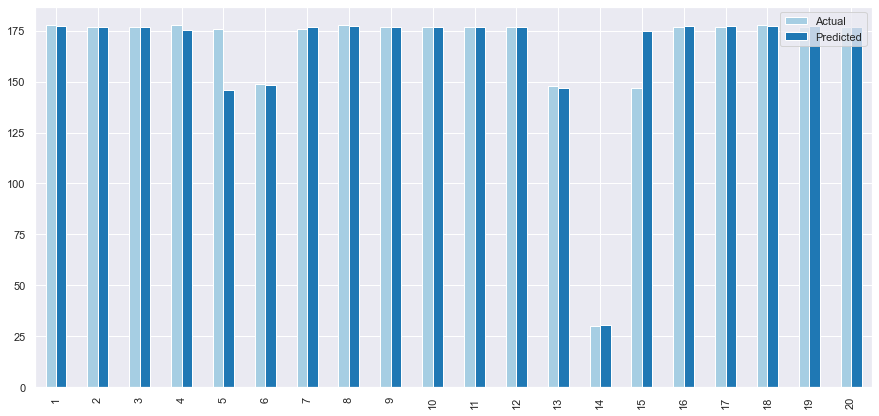

In [1515]:
sns.set_palette('Paired')
x = predict_a_top.head(20)
x.plot(kind='bar',figsize=(15,7))

This is graph on the test set, with the actual intervals as light blue color, and the predicted intervals wth the dark blue color. As you can see, the predictions have ben quite close to each other for the test set, so we can also conclude, that there is no biasedness on the train set, because the accuracyon the test set and this graph pretty well declares that. 

### Date Caluclation

In [1505]:
def jd_to_date(jd):
    jd = jd + 0.5
    F, I = math.modf(jd)
    I = int(I) 
    A = math.trunc((I - 1867216.25)/36524.25)
    if I > 2299160:
        B = I + 1 + A - math.trunc(A / 4.)
    else:
        B = I    
    C = B + 1524 
    D = math.trunc((C - 122.1) / 365.25)
    E = math.trunc(365.25 * D)
    G = math.trunc((C - E) / 30.6001)
    day = C - E + F - math.trunc(30.6001 * G)
    if G < 13.5:
        month = G - 1
    else:
        month = G - 13   
    if month > 2.5:
        year = D - 4716
    else:
        year = D - 4715
        
    return str(year)+":"+str(month)+":"+str(day)

So we have written the function to return convert The Julian day back to the date. But now we will convert the time interval predicted to the Julian day count, since we need Julian day to get the date.
For ith row, we shall add i-1th Julian day to the Predicted time interval between the two rows i and i-1.
So, for first row we have Julian day hat is unchanged, we add that with the second row's time gap to get the second row's Julian day.

In [1506]:
test1.loc[1,'JD predicted'] = test.loc[0,'Time']+test1.loc[1,'Predicted diff']
for i in range(2,len(test1)):
    test1.loc[i,'JD predicted'] = test1.loc[i-1,'Time']+test1.loc[i,'Predicted diff']

In [1507]:
test1 = test1[:-1]

In [1508]:
test1['Predicted date'] = test1['JD predicted'].apply(lambda x:jd_to_date(x))
test1

,Saros Number,Eclipse Type,Eclipse Magnitude,Sun Altitude,Time,Diff,Time normal,Predicted diff,JD predicted,Predicted date
1,134.0,173.492759,8,71.0,2453646.5,178.0,14.713086,177.140,2453645.640,2005:10:2.140000000130385
2,139.0,174.108275,9,67.0,2453823.5,177.0,14.713158,177.028,2453823.528,2006:3:29.027999999932945
3,144.0,173.492759,8,66.0,2454000.5,177.0,14.713230,176.792,2454000.292,2006:9:21.791999999899417
4,149.0,119.026154,8,0.0,2454178.5,178.0,14.713303,175.418,2454175.918,2007:3:16.41800000006333
5,154.0,119.026154,6,0.0,2454354.5,176.0,14.713374,145.926,2454324.426,2007:8:11.925999999977648
...,...,...,...,...,...,...,...,...,...,...
2374,182.0,119.026154,9,0.0,2816222.5,177.0,14.850907,161.166,2816206.666,2998:5:30.166000000201166
2375,187.0,119.026154,4,0.0,2816400.5,178.0,14.850970,37.880,2816260.380,2998:7:22.87999999988824
2376,154.0,174.108275,9,33.0,2816547.5,147.0,14.851022,177.128,2816577.628,2999:6:5.128000000026077
2377,159.0,164.370370,8,0.0,2816724.5,177.0,14.851085,174.946,2816722.446,2999:10:27.945999999996275


In [1509]:
def final_date(s):
    l = s.split(':')
    y = l[0]
    m = l[1]
    d = l[2]
    d = float(d)
    d=int(d)
    return y+"-"+m+"-"+str(d)

In [1510]:
test1['Predicted date'] = test1['Predicted date'].apply(lambda x:final_date(x))

### Final Result

In [1511]:
test_big = test_big[1:-1]
test_big['Predicted date'] = test1['Predicted date']
test_big.to_csv("1805689_test.csv")

In [1512]:
test_big

,Unnamed: 0,Catalog Number,Calendar Date,Eclipse Time,Delta T (s),Lunation Number,Saros Number,Eclipse Type,Gamma,Eclipse Magnitude,Latitude,Longitude,Sun Altitude,Sun Azimuth,Path Width (km),Central Duration,Predicted date
1,9519,9520,2005 October 3,10:32:47,65.0,71,134.0,A,0.3306,0.9576,12.9N,28.7E,71.0,209,162,04m32s,2005-10-2
2,9520,9521,2006 March 29,10:12:23,65.0,77,139.0,T,0.3843,1.0515,23.2N,16.7E,67.0,149,184,04m07s,2006-3-29
3,9521,9522,2006 September 22,11:41:16,65.0,83,144.0,A,-0.4062,0.9352,20.6S,9.1W,66.0,31,261,07m09s,2006-9-21
4,9522,9523,2007 March 19,2:32:57,65.0,89,149.0,P,1.0728,0.8756,61.0N,55.5E,0.0,92,NaN,NaN,2007-3-16
5,9523,9524,2007 September 11,12:32:24,66.0,95,154.0,P,-1.1255,0.7507,61.0S,90.2W,0.0,80,NaN,NaN,2007-8-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,11892,11893,2998 June 15,14:49:27,4410.0,12349,182.0,P,-1.0158,0.9792,66.5S,32.5W,0.0,9,NaN,NaN,2998-5-30
2375,11893,11894,2998 December 10,3:18:31,4414.0,12355,187.0,P,1.2838,0.4773,67.2N,145.0E,0.0,179,NaN,NaN,2998-7-22
2376,11894,11895,2999 May 6,23:23:57,4417.0,12360,154.0,T,0.8388,1.0566,71.5N,177.3E,33.0,146,345,03m25s,2999-6-5
2377,11895,11896,2999 October 30,9:34:33,4420.0,12366,159.0,A-,-1.0023,0.9586,70.9S,84.7W,0.0,137,-,-,2999-10-27


So, as a conclusion, we can definitely see how close the dates have been predicted. Check out the Predicted date column for the prediction and match it with the Calendar date, to see the comparison, I have also done various EDA and FE, and at last using Random Forest Regression, I could predict the intervals between the consecutive eclipses, which in turn gave the Julian day count. From there we could easily calculate our date wth the formula.<br> This work has been solely done by <b> Ritwik Pal, 1805689